In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Reshape
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import image
from keras.utils import load_img, img_to_array
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from IPython.display import Image
import itertools
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.chdir('../../data')

In [2]:
# !git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

In [6]:
mobileNet = tf.keras.applications.mobilenet.MobileNet()

In [7]:
def prepare_image(img_name):
    img_path = '/home/sheded/DataspellProjects/computer vision/data/mobileNet/'
    img = load_img(img_path+img_name, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

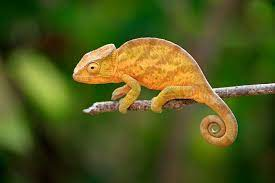

In [8]:
Image(filename='mobileNet/hr.jpg', width=450, height=300)

In [9]:
preprocessed_image = prepare_image('hr.jpg')
predictions = mobileNet.predict(preprocessed_image)

1/1 [==============================] - 1s 1s/step


In [10]:
results = imagenet_utils.decode_predictions(predictions)

In [11]:
results

[[('n01694178', 'African_chameleon', 0.99809724),
  ('n01675722', 'banded_gecko', 0.0018332386),
  ('n01630670', 'common_newt', 2.9890416e-05),
  ('n01644900', 'tailed_frog', 1.6897622e-05),
  ('n01685808', 'whiptail', 1.0182522e-05)]]

### Organize data into train, valid, test dirs

In [12]:
os.chdir('mobileNet/Sign-Language-Digits-Dataset-master/Dataset')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../../..')

In [13]:
train_path = r'mobileNet/Sign-Language-Digits-Dataset-master/Dataset/train'
valid_path = r'mobileNet/Sign-Language-Digits-Dataset-master/Dataset/valid'
test_path = r'mobileNet/Sign-Language-Digits-Dataset-master/Dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224, 224), batch_size=10
)

valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224, 224), batch_size=10
)

test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False
)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [14]:
mobileNet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [15]:
x = mobileNet.layers[-5].output
x

<KerasTensor: shape=(None, 1, 1, 1024) dtype=float32 (created by layer 'global_average_pooling2d')>

In [16]:
reshape = Reshape((1024,))(x)
output = Dense(10, activation='softmax')(reshape)

In [17]:
model = Model(inputs=mobileNet.input, outputs=output)

In [18]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(x=train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, validation_steps=len(valid_batches),
                    epochs=6, verbose=1)

Epoch 1/6


2022-10-06 13:28:50.761764: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16056320 exceeds 10% of free system memory.
2022-10-06 13:28:50.777841: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16056320 exceeds 10% of free system memory.
2022-10-06 13:28:50.794405: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16056320 exceeds 10% of free system memory.
2022-10-06 13:28:50.806752: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32112640 exceeds 10% of free system memory.
2022-10-06 13:28:50.833607: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32688640 exceeds 10% of free system memory.


137/172 [======================>.......] - ETA: 28s - loss: 0.4396 - accuracy: 0.8693

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['traning', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['traning', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_labels = test_batches.classes
test_labels

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
cm

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
model.save('mobileNet/modelv1.h5')

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2022-10-06 15:48:28.567158: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-10-06 15:48:28.567207: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: sheded-Latitude-E6520
2022-10-06 15:48:28.567219: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: sheded-Latitude-E6520
2022-10-06 15:48:28.567920: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-10-06 15:48:28.567956: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 390.154.0
2022-10-06 15:48:28.567967: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 390.154.0 does not match DSO version 510.85.2 -- cannot find working devices in this configuration


[]